# Create NLKV Samples from Trajectories: A Demo

<br/> This notebook provides a demo to create NLKV samples from trajectories. The trajectories used in this demo are a subset of L001F001. The original trajectories can be obtained from https://zen-traffic-data.net/. An application is required to access the data.<br/>We also provide the created LKV and NLKV samples in files named *LKV.csv* and *NLKV.csv*, respectively.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
from C0_plot import draw_fields
from C1_Preprocess import load_data
from C1_Cal_qkva_field_ZEN import cal_qkva_field,cal_DSD

In [ ]:
# # From ZEN L001F001 trajectories to the sample data
# col_name = ['veh_id','datetime','veh_type','velocity','traffic_lane','lng','lat','kilopost','veh_len','detected_flag']
# original_data = pd.read_csv('L001_F001_trajectory.csv',index_col=0,names=col_name)
# sample_data = original_data[(original_data['datetime']<=73318500)&(original_data['datetime']>=70818700)]
# sample_data.to_csv('sample_trj.csv',header=False)

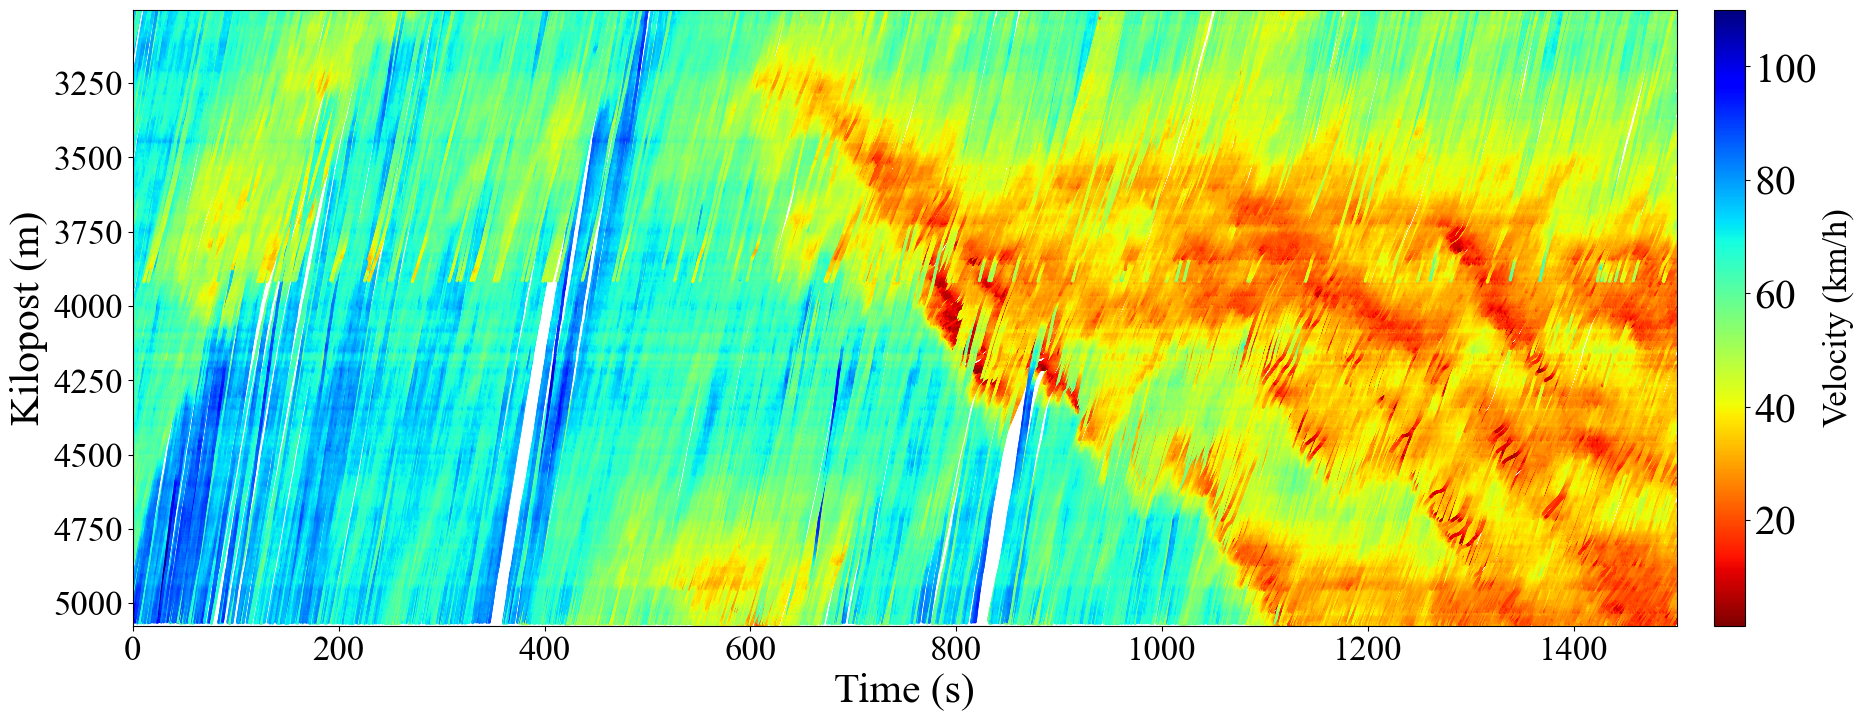

In [4]:
# Preprocess & visualize
trajectory_data = load_data('sample_trj.csv',plot_figure=True,sp_lane=False,inverse=True,cbar=True)

In [5]:
# Fields estimation
m_p = cal_qkva_field(trajectory_data,delta_t=50,delta_x=300,t_step=2,x_step=3,plot_figure=False,rolling=True)

50 300
Calculating acc...


In [ ]:
# Calculate anticipated densdity
m_p = cal_DSD(m_p,t_step=2,x_increase=False)

Done!


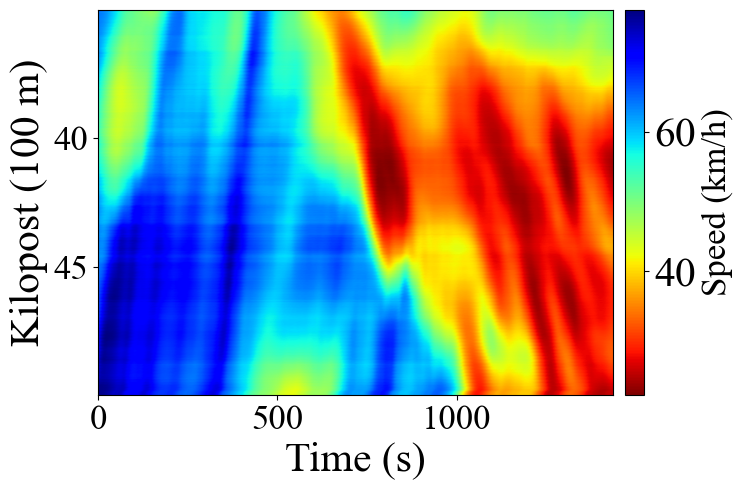

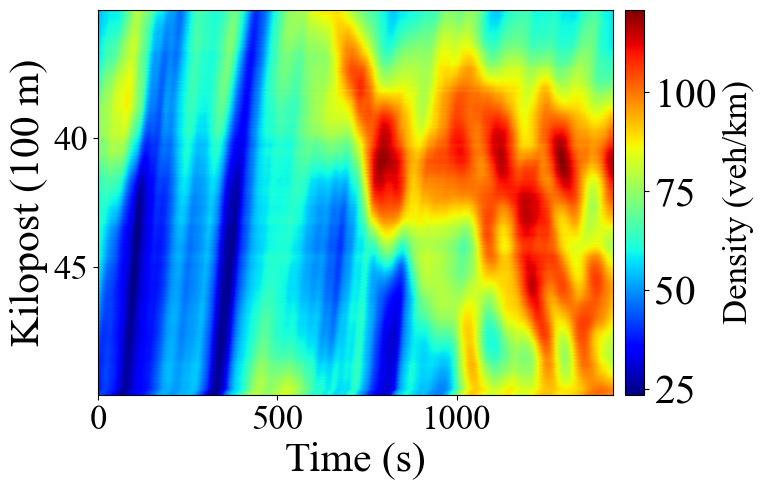

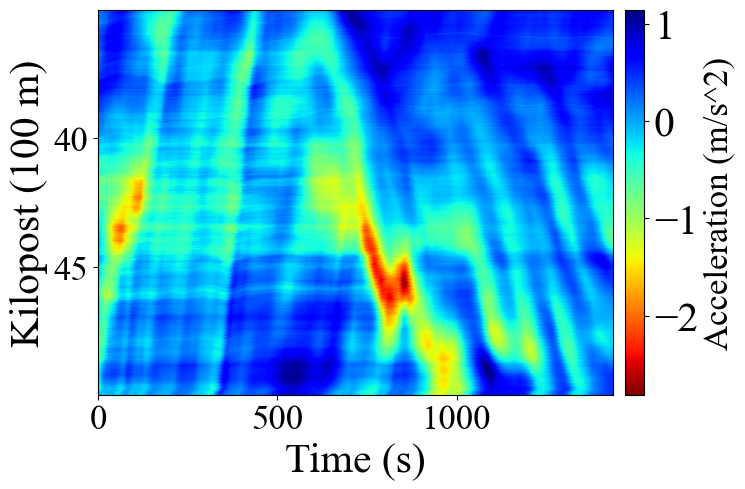

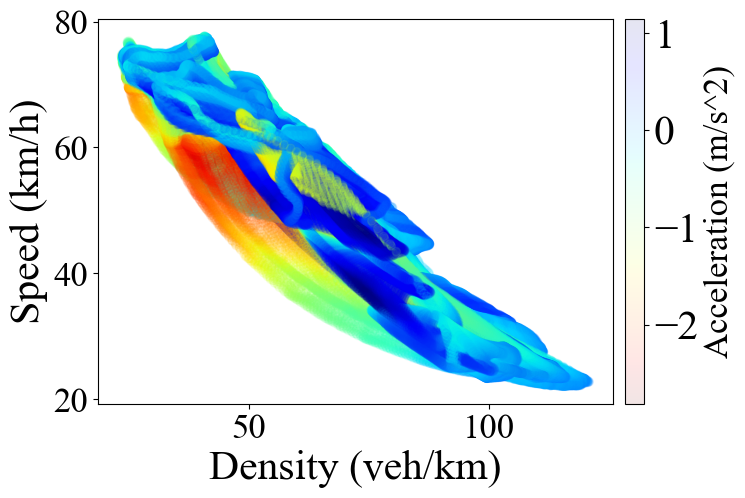

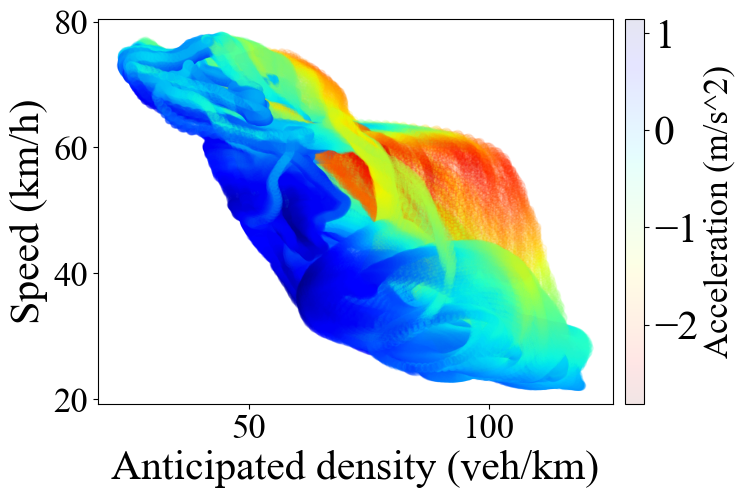

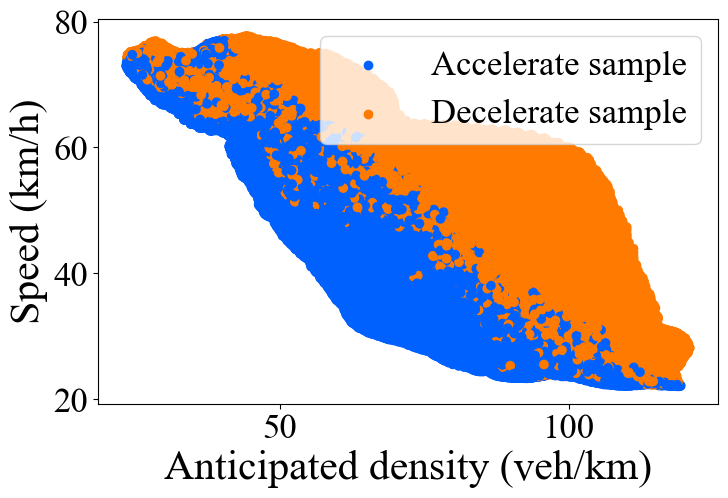

In [9]:
# Visualize fields, LKV, NLKV
draw_fields(m_p,5000,0,1500,3500,subplot=False,kv_FD=True,speed_f=True,density_f=True,acc_f=True,density_a_kv=True,density_a_kq=True,invs=True)

In [10]:
# LKV sampes
LKV = m_p[['k','v']]
LKV.to_csv('LKV.csv')
# NLKV sample
NLKV = m_p[['ka','v']]
NLKV['y'] = np.zeros(shape=len(NLKV))
NLKV['y'][m_p['acc']<=0] = 1
NLKV = NLKV.dropna()
NLKV.to_csv('NLKV.csv')

In [15]:
def cal_DSD(macro_para,t_step,x_increase=True):
    # 计算dsd
    '''更改偏移量计算方法只用改这一小部分,后面的不用变'''
    macro_para['dsd'] = macro_para['v(km/h)']*12.1*0.278
    # 计算dsd对应的空间格子数
    t_len = len(set(macro_para['t']))
    x_step = macro_para.iloc[t_len]['x'] - macro_para.iloc[0]['x']
    if x_increase:          # 如果x的桩号是递增的就用这个,否则用下一个
        macro_para['dsd_x'] = macro_para['x'] + x_step*np.floor(macro_para['dsd']/x_step)
    else:
        macro_para['dsd_x'] = macro_para['x'] - x_step*np.floor(macro_para['dsd']/x_step)
    macro_para['dsd_t'] = macro_para['t'] + t_step*np.floor(12.1/t_step)
    
    up = max(macro_para['x'])
    low = min(macro_para['x'])
    t_up = max(macro_para['t'])
    m = macro_para[['dsd_t','dsd_x']]
    m = m[m['dsd_t']<t_up].values
    macro_para = macro_para[macro_para['dsd_t']<t_up]
    
    ka = []
    i = 0
    for data in m:
        i += 1
        # if i%1000==0:
        #     print(i)
        if (data[1]<=up)&(data[1]>=low):
            kai = macro_para[(macro_para['t']==data[0])&(macro_para['x']>data[1]-0.1)&(macro_para['x']<data[1]+0.1)]['k']
            ka.append(kai.values)
        else:
            ka.append([np.nan])
    
    a = np.full([len(ka),], np.nan)
    for i in np.arange(len(ka)):
        # print(i)
        try:
            a[i] = ka[i][0]
        except:
            try:
                a[i] = ka[i]
            except:
                a[i] = np.nan
        # if i%10000 == 0:
        #     print(i)
        
    macro_para['ka'] = a
    
    return macro_para